### Changes in interchromosomal contacts during infection

_A. castellanii_ forms specific inter-telomeric contacts. Here I investigate whether those contacts are disrupted in any way during infection. As interchromosomal contact matrices generally have a poor signal to noise ratio, I use a larger binning (20kb) and use serpentine adaptative binning to improve the signal.

> Note: both matrices have been subsampled to ~ the same amount of contacts

In [1]:
import os
import numpy as np
import pandas
import cooler
import matplotlib.pyplot as plt
import serpentine as serp
import chromosight.utils.detection as cud
os.chdir('/home/varogh/Repos/acastellanii_legionella_infection/')
# Input cool files have been generated by subsampling - merging all
clu = cooler.Cooler('uninfected_20kb.cool')
cli = cooler.Cooler('infected_20kb.cool')
matu = clu.matrix(sparse=False, balance=False)[:]
mati = cli.matrix(sparse=False, balance=False)[:]
normu = clu.matrix(sparse=False, balance=True)[:]
normi = cli.matrix(sparse=False, balance=True)[:]

Text(0.5, 0.98, 'A. castellanii genome, 20kb')

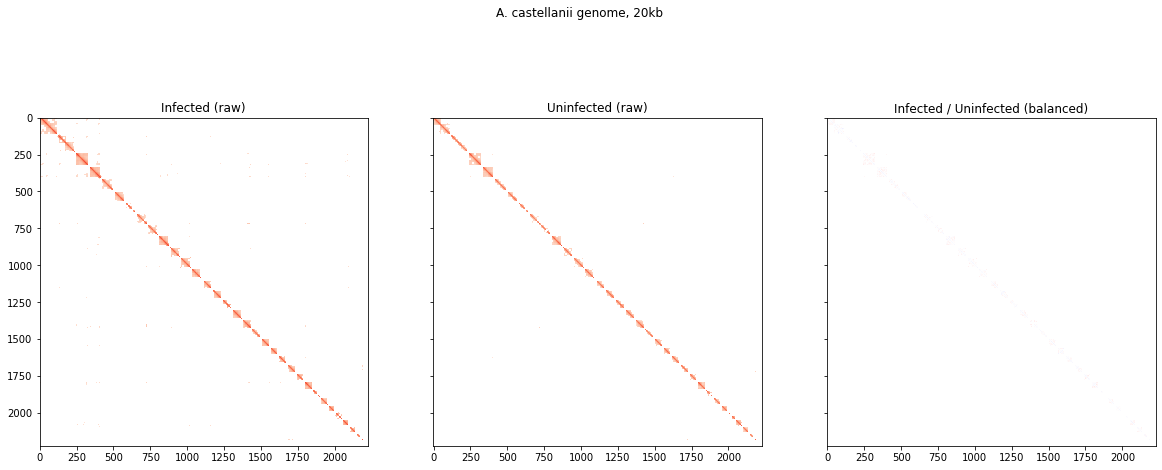

In [2]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20, 8))
ax[0].imshow(np.log2(mati), cmap="Reds")
ax[0].set_title("Infected (raw)")
ax[1].imshow(np.log2(matu), cmap="Reds")
ax[1].set_title("Uninfected (raw)")
ax[2].imshow(np.log2(normi/normu), cmap="bwr")
ax[2].set_title("Infected / Uninfected (balanced)")
plt.suptitle("A. castellanii genome, 20kb")

Now that the low resolution whole genome matrices are loaded, we use serpentine to smooth both matrices and their ratio.

In [2]:
# It takes ages to run, so we cache the output with ipython magic
#seri, seru, srat = serp.serpentin_binning(mati, matu, parallel=6)
#np.savetxt('docs/notebooks/cache/seri.txt', seri)
#np.savetxt('docs/notebooks/cache/seru.txt', seru)
#np.savetxt('docs/notebooks/cache/srat.txt', srat)


Starting 10 binning processes in batches of 6...
0	 Total serpentines: 4955076 (100.0 %)
0	 Total serpentines: 4955076 (100.0 %)
0	 Total serpentines: 4955076 (100.0 %)
0	 Total serpentines: 4955076 (100.0 %)
0	 Total serpentines: 4955076 (100.0 %)
0	 Total serpentines: 4955076 (100.0 %)
1	 Total serpentines: 3299262 (66.58347924431432 %)
1	 Total serpentines: 3300165 (66.60170298094317 %)
1	 Total serpentines: 3299157 (66.58136020517142 %)
1	 Total serpentines: 3299092 (66.58004841903535 %)
1	 Total serpentines: 3299056 (66.57932189132922 %)
1	 Total serpentines: 3300082 (66.60002793095404 %)
2	 Total serpentines: 1139596 (22.99855743887682 %)
2	 Total serpentines: 1139129 (22.989132760022247 %)
2	 Total serpentines: 1139114 (22.98883004014469 %)
2	 Total serpentines: 1140258 (23.01191747613962 %)
2	 Total serpentines: 1139528 (22.997185108765233 %)
2	 Total serpentines: 1139115 (22.988850221469864 %)
3	 Total serpentines: 421853 (8.513552567104924 %)
3	 Total serpentines: 421865 (8.5

In [3]:
seri = np.loadtxt('docs/notebooks/cache/seri.txt')
seru = np.loadtxt('docs/notebooks/cache/seru.txt')
srat = np.loadtxt('docs/notebooks/cache/srat.txt')

We see some long red and blue bands. This suggests some chromosome have more or less contacts with the rest of the genome upon infection.

Text(0.5, 0.98, 'Serpentine-binned A. castellanii genome, 20kb')

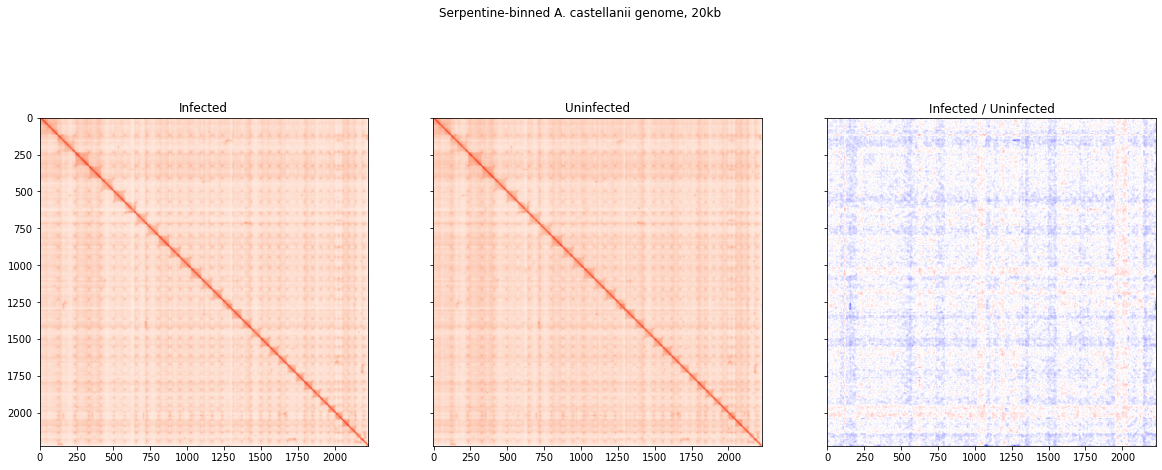

In [4]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20, 8))
ax[0].imshow(np.log2(seri), cmap="Reds")
ax[0].set_title("Infected")
ax[1].imshow(np.log2(seru), cmap="Reds")
ax[1].set_title("Uninfected")
ax[2].imshow(srat, cmap="bwr")
ax[2].set_title("Infected / Uninfected")
plt.suptitle("Serpentine-binned A. castellanii genome, 20kb")



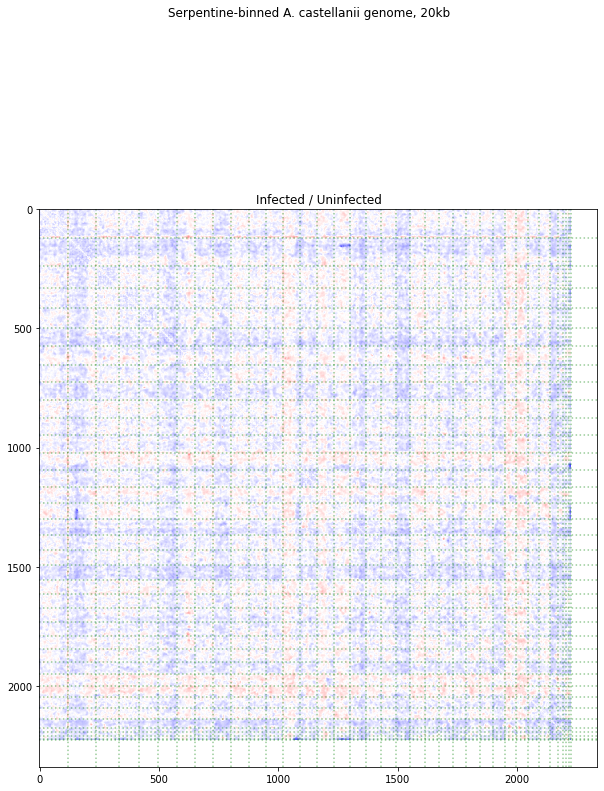

In [5]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 14))
ax.imshow(srat, cmap="bwr")
ax.set_title("Infected / Uninfected")
plt.suptitle("Serpentine-binned A. castellanii genome, 20kb")
for chrom in clu.chroms()[:].name:
    ax.axvline(clu.extent(chrom)[1], alpha=0.4, c='g', ls=':')
    ax.axhline(clu.extent(chrom)[1], alpha=0.4, c='g', ls=':')

### Groups of chromosomes

These bands could suggest there are groups (clusters) of chromosomes. To investigate it, we'll simplify the matrix into a pairwise interaction heatmap where each row / col is a single chromosome. Each pixel of this heatmap gives the average interaction between two chromosomes.

In [6]:
def interchrom_graph(clr, mat):
    n_chroms = clr.chroms()[:].shape[0]
    sim_mat = np.zeros((n_chroms, n_chroms))
    for i1, c1 in enumerate(clr.chroms()[:].name):
        for i2, c2 in enumerate(clr.chroms()[:].name):
            if c1 == c2:
                sim_mat[i1, i2] = 1
                continue
            s1, e1 = clr.extent(c1)
            s2, e2 = clr.extent(c2)
            sim_mat[i1, i2] = mat[s1:e1, s2:e2].mean()
    return sim_mat
graphi = interchrom_graph(cli, mati)
graphu = interchrom_graph(clu, matu)

Text(0.5, 0.98, 'Pairwise interchromosomal contact intensity')

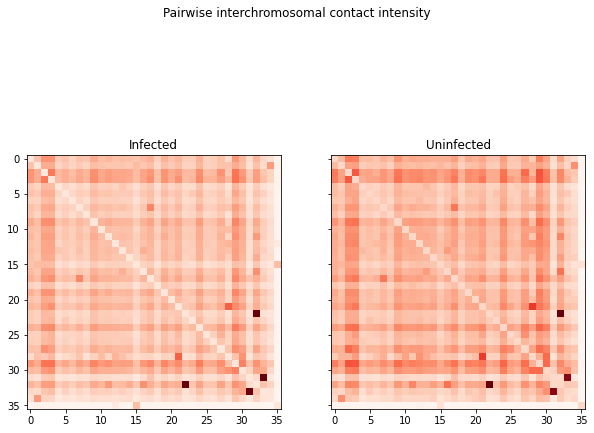

In [7]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8))
for a, cond, g in zip(ax, ['Infected', 'Uninfected'], [graphi, graphu]):
    a.imshow(g - g.mean(), cmap='Reds')
    a.set_title(cond)
plt.suptitle("Pairwise interchromosomal contact intensity")

The pairwise chromosomal contacts maps are quite similar between conditions, but there seem to be more contrast in uninfected cells. To see more clearly if there are actually groups of tightly connected chromosomes, we can use PCA to generate a scatterplot that summarizes well interchromosomal contacts.

Text(0.5, 0.98, 'PCA of pairwise inter contacts. \nSize proportional to chrom. lengths')

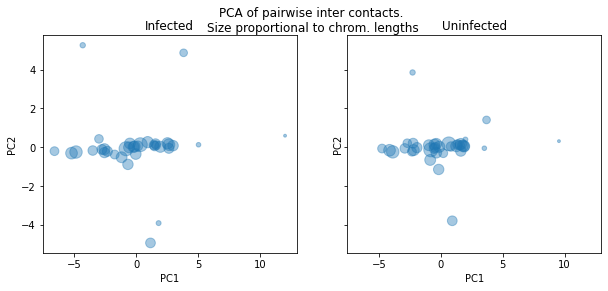

In [8]:
from sklearn.decomposition import PCA
pca = PCA()
chromlens = clu.chroms()[:].length
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
for a, cond, g in zip(ax, ['Infected', 'Uninfected'], [graphi, graphu]):
    pcs = pca.fit_transform(g)
    a.scatter(pcs[:, 0], pcs[:, 1], s=200* chromlens / max(chromlens), alpha=0.4)
    a.set_xlabel("PC1")
    a.set_ylabel("PC2")
    a.set_title(cond)
plt.suptitle("PCA of pairwise inter contacts. \nSize proportional to chrom. lengths")

Again, both conditions look similar. Rather than two groups of chromosomes, it seems there is one main group and a few outliers. From the PCA these outliers seem to be more pronounced in the infected cells. Note that in this context, an outlier is not a chromosome with fewer contacts to others, but a chromosome whose contact pattern differs from other chromosomes. An outlier in the scatterplot is different from a white line in the heatmap above.

Alternatively, we can visualise the interchromosomal contacts as a force-directed graph in each condition. Each chromosome is a node, and their interactions strength define the length of the edge. The stronger the interactions, the shorter the edge:

In [9]:
%matplotlib inline
import networkx as nx
from sklearn.cluster import AgglomerativeClustering

    
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

for a, m, c in zip(ax.flat, [graphi, graphu], ['infected', 'uninfected']):
    clusters = AgglomerativeClustering(3).fit_predict(m)
    nx.draw_kamada_kawai(
        nx.Graph(m),
        with_labels=True,
        node_color=clusters,
        node_size=400,
        edge_color='grey',
        linewidths=.1,
        font_size=15,
        alpha=0.3,
        ax=a,
    )
    a.set_title(c)
plt.suptitle("Network of interchromosomal contacts")

ModuleNotFoundError: No module named 'networkx'

This clearly shows that most chromosomes are packed together except for 3 isolated chromosomes. These 3 are the same in both conditions, but the isolation seems stronger in infected cells (not sure). We need some way to visualize the change between the two graphs to make sure.

I extracted the same pairwise interchromosomal heatmap from the serpentine ratio map. Each pixel of the heatmap below is the relative amount of contacts between Infected / uninfected conditions for a pair of chromosome. If a pixel is red, it means the pair of chromosome interacts more strongly. The main thing we can see is that scaffolds 28 and 29 are interacting more strongly with all other chromosomes.

Text(0.5, 1.0, 'Per chromome net interchromosomal contact changes')

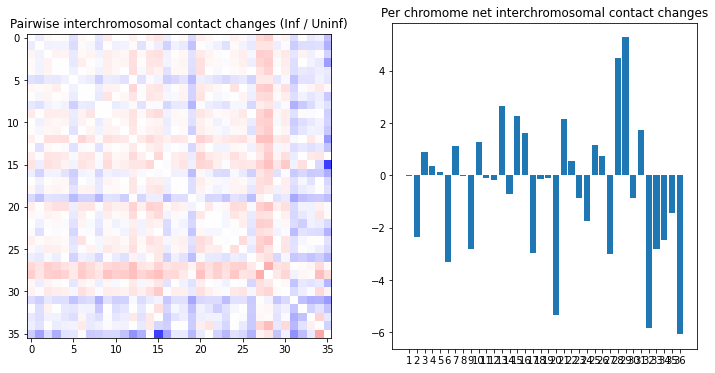

In [10]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
graphs = interchrom_graph(clu, srat-srat.mean())
np.fill_diagonal(graphs, 0)
ax[0].imshow(graphs, cmap='bwr', vmin=-1, vmax=1)
ax[0].set_title('Pairwise interchromosomal contact changes (Inf / Uninf)')
ax[1].bar(x=clu.chroms()[:].name.str.replace('scaffold_', ''), height=graphs.sum(axis=1))
ax[1].set_title('Per chromome net interchromosomal contact changes')

If we reorder chromosomes in the heatmap according to their similarity (in contact changes), we can see a few clusters appearing. There are a few outliers, including scaffold 28 and 29, a large group of chromosomes whose contacts are increased with 28-29, and a smaller group of 7 chromosomes which are not affected.

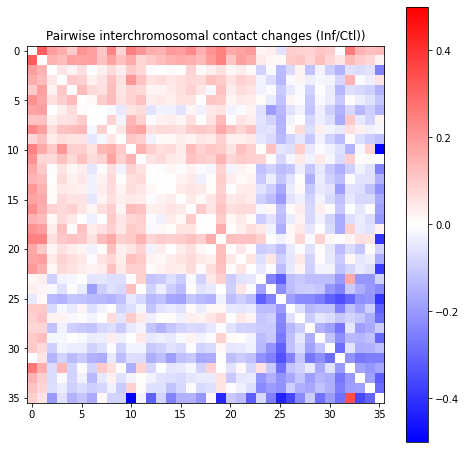

In [21]:
%matplotlib inline
import pandas as pd
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]
plt.figure(figsize=(8, 8))
plt.imshow(cluster_corr(graphs), cmap='bwr', vmin=-0.5, vmax=0.5)
plt.title("Pairwise interchromosomal contact changes (Inf/Ctl))")
plt.colorbar()

The global share of interchromosomal contacts increases during infection

In [23]:
intrai = 0
intrau = 0
for chrom in clu.chroms()[:].name:
    s, e = clu.extent(chrom)
    intrai += np.triu(mati[s:e, s:e]).sum()
    intrau += np.triu(matu[s:e, s:e]).sum()
print(f"Infected: {100*(1-intrai / cli.info['sum']):.2f}% interchromosomal contacts")
print(f"Uninfected: {100*(1-intrau / clu.info['sum']):.2f}% interchromosomal contacts")

Infected: 4.96% interchromosomal contacts
Uninfected: 3.61% interchromosomal contacts


### Inter-telomeric contacts

One feature that stands out in the whole genome Hi-C contact map is that chromosome have increased contacts between telomeres. Here I investigate these specific interaction patterns.

Extracting the windows around each inter-telomeric coordinate reveals that most chromosome have stronger telomeric clustering upon infection. There are a few outlier chromosomes which seem to behave differently.

In [24]:
WINRAD = 11
WINSIZE = WINRAD * 2 + 1
chrom_telo_win = {chrom: [] for chrom in clu.chroms()[:].name}
chroms = clu.chroms()[:]
ends = [0, clu.shape[0]]
for c1 in chroms.name:
    for c2 in chroms.name:
        if c1 == c2:  # Skip intra
            continue
        for i in clu.extent(c1):
            for j in clu.extent(c2):
                if i == j: # Skip neighbouring chromosomes (diagonal)
                    continue
                if i in ends or j in ends: # Skip first and last telomeres
                    continue
                win = srat[i-(WINRAD+1): i+WINRAD, j-(WINRAD+1): j+WINRAD]
                if win.shape == (WINSIZE, WINSIZE):
                    chrom_telo_win[c1].append(win)
                    chrom_telo_win[c2].append(win)

In [25]:
chrom_agg = {
    chrom: np.apply_along_axis(np.nanmedian, 2, np.dstack(wins)) for chrom, wins in chrom_telo_win.items() if len(wins)
}

Text(0.5, 0.98, 'Infected / Uninfected telomeric contacts')

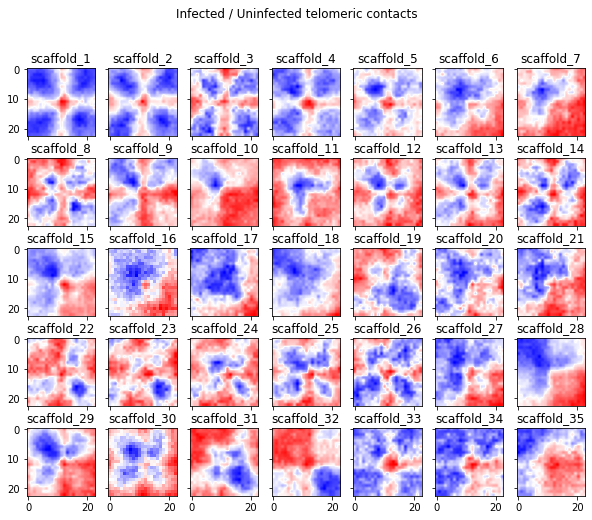

In [26]:
%matplotlib inline
fig, ax = plt.subplots(5, 7, sharex=True, sharey=True, figsize=(10, 8))
for a, (chrom, pileup) in zip(ax.flat, chrom_agg.items()):
    a.imshow(pileup, cmap='bwr')
    a.set_title(chrom)
plt.suptitle("Infected / Uninfected telomeric contacts")
#plt.savefig("~/pCloudDrive/reports_phd/20200617_acastellanii_ms/assets/intertelomeric_infection_ratio.svg")

We can also visualise this as a 4C-like profile. The 4C profile of each chromosome is extracted by taking the sum of interchromsomal contact for each of its bins.

Here, I resized each chromosome's profile so that they are all the same length. We can see that several chromosomes have a very strong contact enrichment towards the centromeres, but this is not the case for all of them.

In [40]:
profiles = {}
for chrom in clu.chroms()[:].name:
    s, e = clu.extent(chrom)
    profiles[chrom] = srat[s:e, :].mean(axis=1)
    

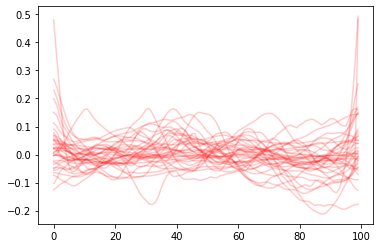

In [41]:
%matplotlib inline
import scipy.ndimage as ndi
img = np.zeros((len(profiles), 100))
for i, (chrom, prof) in enumerate(profiles.items()):
    zoomed = ndi.zoom(prof, 100 / len(prof))
    img[i, :] = zoomed - zoomed.mean()
    plt.plot(zoomed - zoomed.mean(), alpha=0.2, c='red')
#plt.imshow(img, cmap='bwr', vmax=2, vmin=-2)

If we want to quantify the strength of telomere clustering before and after infection, so we need to generate a chromosight kernel for telomere clustering.

In [42]:
def get_inter_telo(clr):
    """
    Yields bin coordinates of inter-telomeric positions.
    Skips intrachromosomal and neighbouring chromosome contacts
    """
    chroms = clr.chroms()[:]
    ends = [0, clr.shape[0]]
    for c1 in chroms.name:
        for c2 in chroms.name:
            if c1 == c2:  # Skip intra
                continue
            for i in clu.extent(c1):
                for j in clu.extent(c2):
                    if i == j: # Skip neighbouring chromosomes (diagonal)
                        continue
                    if i in ends or j in ends: # Skip first and last telomeres
                        continue
                    yield(i, j)

In [43]:
# Compute pileup between all pairs of telomeres
wins = []

for i, j in get_inter_telo(clu):
    win = matu[i-(WINRAD+1): i+WINRAD, j-(WINRAD+1): j+WINRAD]
    if win.shape == (WINSIZE, WINSIZE):
        wins.append(win)

wins = np.dstack(wins)
pileup = np.apply_along_axis(np.nanmedian, 2, wins)
# Enforce symmetry by adding all rotations
rot = pileup.copy()
for i in range(3):
    rot = np.rot90(rot)
    pileup += rot

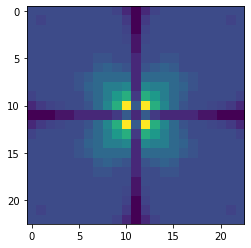

In [44]:
%matplotlib inline
plt.imshow(pileup)

We can now convolute that kernel on the raw contact matrices. Note that both matrices have the same amount of contacts, but since the proportion of inter contacts is different, there are actually more inter-contacts in the infected map, the convolution coefficients will be higher. To address this issue, I remove all intrachromosomal contacts in both matrices and subsample them to the same number of interchromosomal contacts.

In [47]:
import hicstuff.hicstuff as hcs
import scipy.sparse as sp
def remove_intra(mat, clr):
    for chrom in clr.chroms()[:].name:
        s, e = clr.extent(chrom)
        mat[s:e, s:e] = 0
    return mat

interu = remove_intra(matu.copy(), clu)
interi = remove_intra(mati.copy(), clu)
target = min(interi.sum(), interu.sum())
interu = hcs.subsample_contacts(sp.coo_matrix(interu), target).toarray()
interi = hcs.subsample_contacts(sp.coo_matrix(interi), target).toarray()

In [55]:
convu, _ = cud.normxcorr2(interu, pileup)
convu[convu<0.1] = 0
convi, _ = cud.normxcorr2(interi, pileup)
convi[convi<0.1] = 0

Both whole genome matrices have been convoluted, I removed low (<0.1) convolution values to reduce white noise. We see mostly red spots on inter-telomeric regions, implying that infected cells likely have stronger telomere clustering.

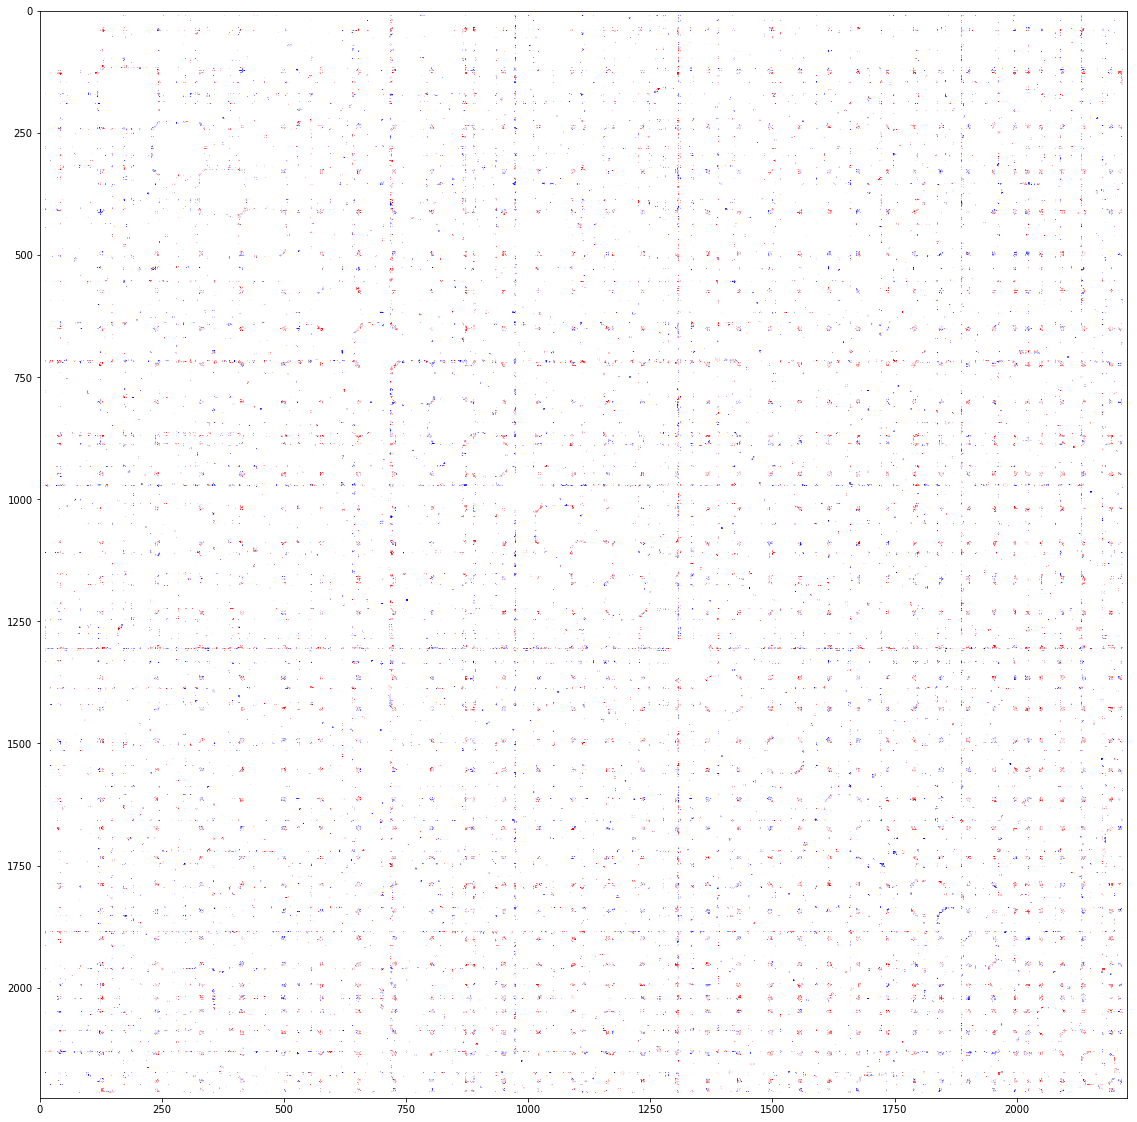

In [76]:
%matplotlib inline
import scipy.ndimage as ndi
plt.figure(figsize=(20, 20))
plt.imshow(np.log2(convi / convu), vmin=-1, vmax=1, cmap='bwr')

Again, we can summarise all this information into a pairwise interchromosomal matrix. Each pair of chromosome has 4 possible telomeric interactions (start-start, start-end, end-end, end-start). We therefore compute a pairwise interaction cube of NxNx4. Each value in that cube is a convolution score with the telomere kernel for a pair of telomeres. For each pair of chromosomes we use the average of the 4 convolution values.

> Note: Not all chromosome pairs will have 4 scores, as some are discarded because they are on the edge of the map (first and last telomere of the genome), or start-end or end-start of neighbouring chromosomes.

In [57]:
def get_inter_conv_dist_mat(clr, conv):
    """
    Populate a cube of inter-telomeric convolution scores.
    The cube has shape NxNx4 where N is the number of chromosomes.
    4 stands for the combination of start-end interactions.
    Skipped combinations (same chromsome, on diagonal,
    chromosome too small) are set to np.nan
    """
    chroms = clr.chroms()[:]
    inter_conv = np.zeros((chroms.shape[0], chroms.shape[0], 4))
    ends = [0, clr.shape[0]]
    for idx1, c1 in enumerate(chroms.name):
        for idx2, c2 in enumerate(chroms.name):
            if c1 == c2:  # Skip intra
                inter_conv[idx1, idx2, :] = np.nan
                continue
            comb = 0
            for i in clu.extent(c1):
                for j in clu.extent(c2):
                    if i == j: # Skip neighbouring chromosomes (diagonal)
                        inter_conv[idx1, idx2, comb] = np.nan
                        comb += 1
                        continue
                    if i in ends or j in ends: # Skip first and last telomeres
                        inter_conv[idx1, idx2, comb] = np.nan
                        comb += 1
                        continue
                    inter_conv[idx1, idx2, comb] = conv[i-1:i+2, j-1:j+2].mean()
                    comb += 1
    return inter_conv

In [78]:
inter_convu = get_inter_conv_dist_mat(clu, convu)
inter_convi = get_inter_conv_dist_mat(cli, convi)

Telomere clustering is globally increased during infection. Only the first and last scaffold seem to have a decrease. maybe this is some kind of artifact ?

Text(0.5, 0.98, 'Strength of telomere clustering between pairs of chromosomes')

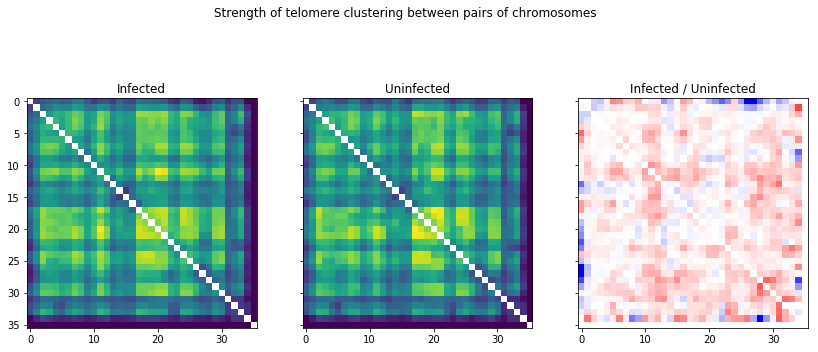

In [79]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14, 6))
ax[0].imshow(np.apply_along_axis(np.nanmean, 2, inter_convi))
ax[0].set_title('Infected')
ax[1].imshow(np.apply_along_axis(np.nanmean, 2, inter_convu))
ax[1].set_title('Uninfected')
ax[2].imshow(np.log2(np.apply_along_axis(np.nanmean, 2, inter_convi)/np.apply_along_axis(np.nanmean, 2, inter_convu)), vmin=-1, vmax=1, cmap='bwr')
ax[2].set_title('Infected / Uninfected')
plt.suptitle("Strength of telomere clustering between pairs of chromosomes")

In [60]:
convsrat = np.log2(np.apply_along_axis(np.nanmean, 2, inter_convi)/np.apply_along_axis(np.nanmean, 2, inter_convu))
convsrat[~np.isfinite(convsrat)] = 0

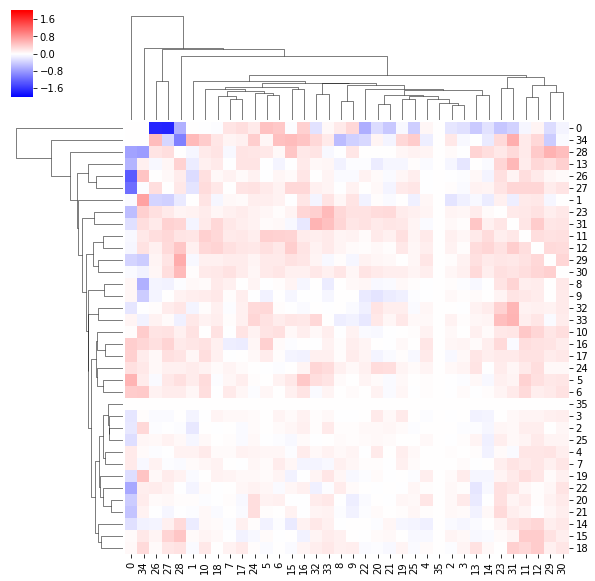

In [61]:
%matplotlib inline
import seaborn as sns
sns.clustermap(convsrat, cmap='bwr',  z_score=None, vmin=-2, vmax=2)

### Sequence composition

I wanted to check whether the sequence composition of telomeric region is different from the rest of the genome.
To answer that, I computed several sequence features in non-overlapping 2kb segment along the genome.

I consider telomeric regions to be 20kb long.

In [9]:
genome = 'data/input/genome/C3.fa'
windows = 'data/tmp/C3_genome_2kb_wins'

In [19]:
 %%bash -s "$genome" "$windows" 

seqkit seq -g --min-len 100000 $1 \
   | dnaglider -fields  "GC,GCSKEW,ATSKEW,ENTRO" \
               -threads 4 \
               -window  2000 \
               -stride  2000 \
               -fasta   - \
               -out     $2

In [27]:
import pandas as pd
wins = pd.read_csv(windows, sep='\t')

In [35]:

telo_size=20000

left_telo = wins.groupby('chrom').start.apply(lambda g: g < telo_size)
right_telo = wins.groupby('chrom').end.apply(lambda g: g > (g.max() - telo_size))
wins['telomere'] = left_telo | right_telo

There does not seem to be a particular relationship between telomeric region and sequence composition

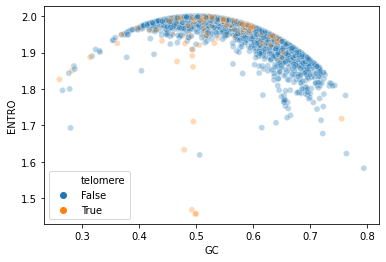

In [54]:
%matplotlib inline 
import seaborn as sns
sns.scatterplot(data=wins, x="GC", y="ENTRO", hue="telomere", alpha=0.3)

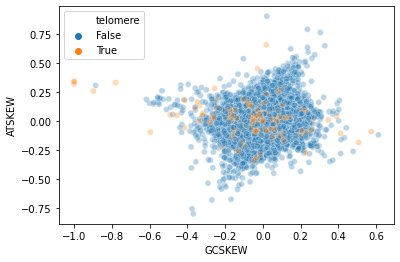

In [55]:
sns.scatterplot(data=wins, x='GCSKEW', y='ATSKEW', hue='telomere', alpha=0.3
)

If we focus on scaffold 4, plotting the local value of different feature vs genomic coordinate, we can see no particular drop or increase in any feature.

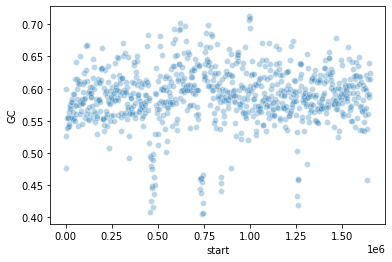

In [56]:
sns.scatterplot(data=wins.loc[wins.chrom=='scaffold_4', :], x='start', y='GC', alpha=0.3)

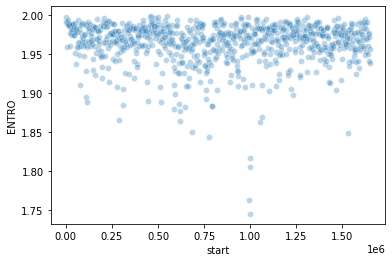

In [57]:
sns.scatterplot(data=wins.loc[wins.chrom=='scaffold_4', :], x='start', y='ENTRO', alpha=0.3)

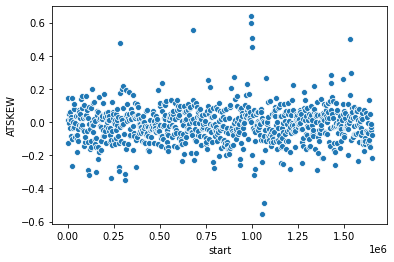

In [53]:
sns.scatterplot(data=wins.loc[wins.chrom=='scaffold_4', :], x='start', y='ATSKEW')